## Work out wet and dry years for Galilee based on a large polygon as defined by GW

This notebook starts by using gridded daily BoM data to find wet and dry years using the available BoM data (oct 1987 - oct 2012). We find driest years as the driest Oct-Oct period (hydrological year) for the rainfall grid. This is done by taking the yearly average of the daily rainfall, then plotting the minimum value by value and also by year.


** Code dependencies **
-code needs to be run in Python 3, unlike the geomedian which currently relies on Python2

- polygon with the extents desired (set up to run only on the outline)


Based on rainfall code originally created by Claire Krause in November 2016 using Datacube version 1.1.13 & Python v3
Modified by Bex Dunn March 2017.
Bex edit to include a polygon over which to calculate the wet and dry years, from the BOM Geofabric, Surface Hydrolgy Catchments http://www.bom.gov.au/water/geofabric/

In [3]:
%matplotlib inline

# Import libraries
import os
import pickle
import datacube
import numpy as np
import xarray as xr
import scipy.stats
import pandas
import csv
import logging
#not sure if we need date time in addition to pandas
import datetime

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.storage.masking import mask_valid_data as mask_invalid_data

#get shapely for dealing with polygons, descartes for plotting and matplotlib patches to fill in the polygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import MultiPolygon

#Libraries for plots
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns

#module for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
from osgeo import gdal

#python logging 
logging.getLogger('datacube.storage.storage').setLevel(logging.ERROR)
dc = datacube.Datacube(app='dc-BOMrainfall')

In [4]:
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    source co-ordinate reference system to destination coordinate reference system
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

#mask to use with our polygons to calculate wet and dry years 
#(comes from http://agdc-v2.readthedocs.io/en/stable/user/guide.html#code-recipes)
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [5]:
#pick a shape file. or #FIXME work out how to iterate over shapes in a shapefile
shape_file = '/g/data/r78/rjd547/groundwater_activities/GalileeBasin/shapefiles/GAI_regional/Gal_for_wetdry3_Nogrid_WGS84.shp'
with fiona.open(shape_file) as shapes:
    geom_crs = geometry.CRS(shapes.crs_wkt)
    first_geo = next(iter(shapes))['geometry']
    #first_geo = next(shapes)['geometry']
    #geopolygon = geometry.Geometry(geom, geom_crs)
    geom = geometry.Geometry(first_geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(next(iter(shapes))['geometry'])
    
shape_name = shape_file.split('/')[-1].split('.')[0]

In [6]:
#running for october 1987 to October 2012 
query = {
        'time': ('1987-10-01','2012-10-01'),
#          'x': (geom.bounds[0], geom.bounds[2]),
#          'y': (geom.bounds[1], geom.bounds[3]),
        'geopolygon': geom 
#         'crs': geom_crs,
    }

## Load `bom_rainfall` grids from the datacube (or from file)

In [7]:
#setup rain directory where we have put our pickle data
rainpath ='/g/data/r78/rjd547/groundwater_activities/Rain/'+shape_name+'050617'+'/'

In [8]:
try:
        os.mkdir(rainpath)
except OSError as err:
        print("OS error: {0}".format(err))

OS error: [Errno 17] File exists: '/g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84050617/'


In [9]:
try:
    #try to get the rain data from a pickle file saved earlier
    f = open(rainpath+'/Rainfall_data'+'.pkl', 'rb')
    rain = pickle.load(f)
    Studysite_rain = rain['Studysite_rain']
    print('loaded rainfall grids from file:'+rainpath+'Rainfall_data.pkl')
    f.close()
except:
    #Grab bom_rainfall_grids from the datacube
    print('loading bom rainfall grids from datacube')
    Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
    #make a dictionary of the data we want to save
    vars2pickle = {'Studysite_rain':Studysite_rain}
    f = open(rainpath+'/Rainfall_data'+'.pkl', 'wb')
    pickle.dump(vars2pickle,f) 
    print('saving rainfall data to file')
    #pickle.dump(vars2pickle,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()

loaded rainfall grids from file:/g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84050617/Rainfall_data.pkl


## Resample to yearly values, using the mean
The totally yearly rainfall (or sum over time) would seem to make sense, but our first and last year are incomplete, and are thus not able to be compared to all the others. It's nicer to not lose the data from them by using mean, rather than excluding them.

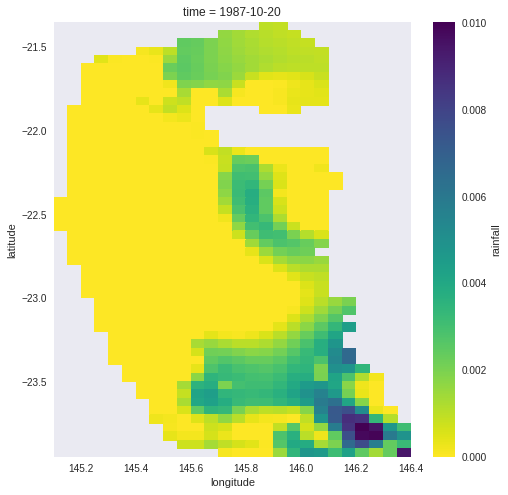

In [10]:
#Mask the data with the polygon. Invert = True means you want the contents of the mask
#I've added 'all touched = True, otherwise we get nothing in the output.
mask = geometry_mask([geom], Studysite_rain.geobox, all_touched=True,invert=True)
Studysite_rain_masked = Studysite_rain.where(mask)
#Plot at t[-1]
plt.figure(figsize=(8,8))
fig = Studysite_rain_masked.rainfall.isel(time = [19]).plot()
#reverse the colourmap so high rainfall is blue
fig.set_cmap('viridis_r')
#print (Studysite_rain_masked)
plt.show()

In [11]:
print (mask)

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]
 [False False False ...,  True  True  True]]


In [12]:
#resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
#Note that the resampling we did means that each year is labelled according to its first day  
year_avg = Studysite_rain_masked.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)

## Plot rainfall by year

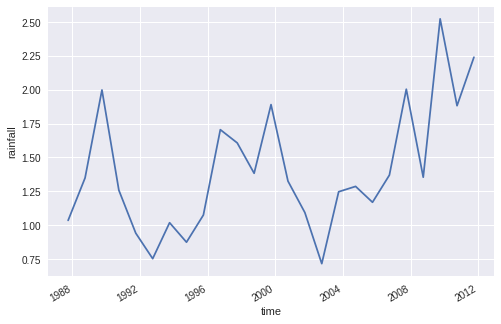

In [13]:
plt.figure()
year_avg.rainfall.mean(dim=('latitude', 'longitude')).plot()
plt.show()

In [14]:
#minimum yearly value in space for each year
driest_mm = year_avg.min(dim = 'time', keep_attrs = True)
#print(driest_mm)

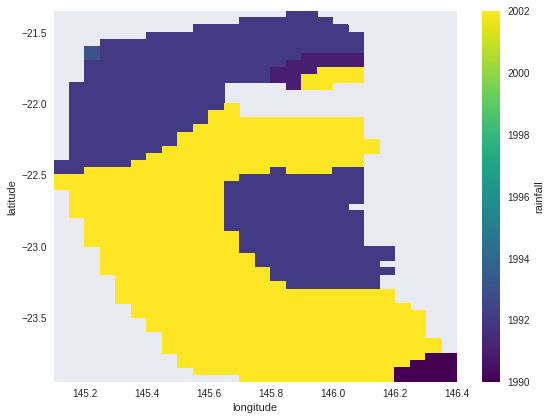

In [15]:
# Calculate the index of the minimum value through time
# Need to work in numpy/masked array land because we have entire time slices that are nan

m = year_avg.rainfall.where(year_avg.rainfall != 0).to_masked_array()
#m[m == 0] = np.inf
# idx = np.nanargmin(m, axis=0)
idx = m.argmin(axis=0, fill_value=-100)

# re-mask our data
idx = np.ma.array(idx, mask=np.all(m.mask, axis=0))

# Plug our indexes back into xarray.DataArray land
dates = year_avg.rainfall.any(dim='time',keep_attrs=True).copy() # Make a temp xarray dataset to keep the coordinates and plug our data in
#note that we start at 1987 now! 
dates.data = idx + 1987

# Mask out data that we know to be null/NaN
valid_values = year_avg.rainfall.notnull().all(dim='time')
dates = dates.where(valid_values)

# Print and plot the data
#print(dates)
plt.figure(figsize=(8,6))

#how many years in the time series?
years = (year_avg.rainfall.time.size)

#separate the colour map into n years
dates.plot()
plt.tight_layout()
plt.show()

#try this with a moving average

## This section under development
-aggregate modal dry years
-spaces in dry year plot? non-unique

In [1]:
#GridSpec
#make this bigger and plot the year next to it
plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2)
ax0 = plt.subplot(gs[0, 0])
ax0 = driest_mm.rainfall.plot()
ax0.set_cmap('inferno_r')

#cmap = colors.ListedColormap(['white', 'red'])
#bounds=[range()]
#norm = colors.BoundaryNorm(bounds, cmap.N)

# sns.hls_palette(years)
# sns.plt.subplot()

ax1 = plt.subplot(gs[0, 1])
patches = []
#have to append the points to the boundary of the patch
for idx, p in enumerate(geom_bs):
    #edge colour and facecolour set, and polygon patch sticks the points together
    patches.append(PolygonPatch(p, ec = 'red', fc = 'orange'))
#add our collection of patches to the plot    
ax1.add_collection(PatchCollection(patches, match_original=True))
#rescale the axes, otherwise you get tiny axes and no plot
minx, miny, maxx, maxy =geom_bs.bounds
w, h = maxx - minx, maxy - miny
ax1.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
ax1.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
ax1.set_aspect(1)
ax1 = dates.plot()

plt.suptitle('Rainfall for driest year for region by daily ave(mm) and driest year for region', fontsize =18)
gs.update(wspace = 0.25) 
plt.show()

#gdal clump and sieve, enumerated raster/raster attribute table image format kea tuiview

NameError: name 'plt' is not defined

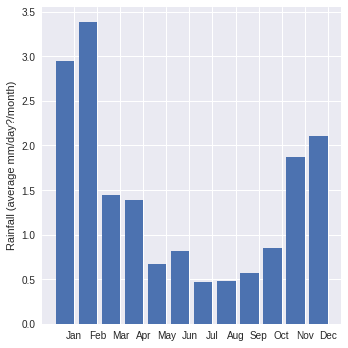

In [18]:
# Resample to monthly data + take the means
monthly_avg = Studysite_rain_masked.groupby('time.month').mean()

# Draw up a bar chart for this site showing the rainfall climatology

fig, ax = plt.subplots(figsize=(5,5))
width=0.8
plt.bar(monthly_avg.month -1,monthly_avg.rainfall, width = width)

# Setting the x-axis and y-axis limits
#plt.xlim([-0.5, 12.2])
#plt.xlim([0, 11.8])
#if monthly_avg.rainfall.max() >= 10:
#    plt.ylim([0, 20])
#else:
#    plt.ylim([0, 10])

# Set the y axis label
ax.set_ylabel('Rainfall (average mm/day?/month)')
ax.set_yticks(np.arange(0,int((max(monthly_avg.rainfall))+1),0.5))
#plt.title(Studysite.Name + ' monthly average daily rainfall 1986 - 2016')

# Set the labels for the x ticks
ax.set_xticks(np.arange(len(monthly_avg.month)) + width/2)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun', 'Jul','Aug','Sep','Oct','Nov','Dec'])

plt.tight_layout()
plt.show()

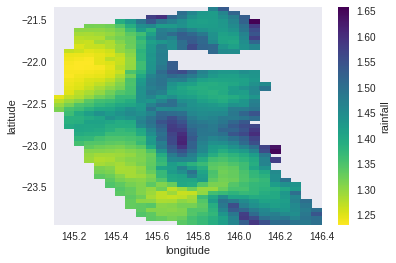

In [19]:
#make a plot of average daily rainfall across the region
%matplotlib inline
fig = Studysite_rain_masked.rainfall.mean(dim = 'time').plot()
fig.set_cmap('viridis_r')
plt.show()

####  Now we have the data, resample it to get a yearly average. 
See http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases for  resampling options

In [20]:
#check that the starting and ending times are what we expect
# Change the format so that it's YYYY-MM-DD
print ('start of rainfall data', np.array(year_avg.isel(time=[0]).time, dtype = 'datetime64[D]'))
print ('end of rainfall data', np.array(year_avg.isel(time=[-1]).time, dtype = 'datetime64[D]'))

start of rainfall data ['1987-10-01']
end of rainfall data ['2011-10-01']


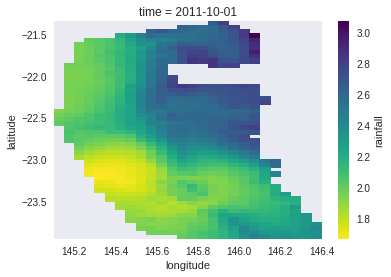

In [21]:
%matplotlib inline
# Plot values across our box to check the spatial distribution
plt.figure()
year_avg.isel(time = -1).rainfall.plot().set_cmap('viridis_r')
plt.show()


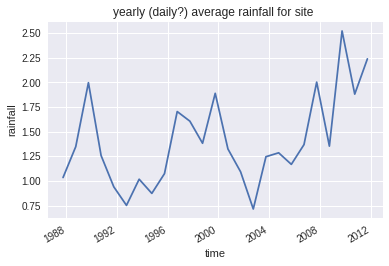

<xarray.Dataset>
Dimensions:   (time: 25)
Coordinates:
  * time      (time) datetime64[ns] 1987-10-01 1988-10-01 1989-10-01 ...
Data variables:
    rainfall  (time) float32 1.03494 1.34836 1.99794 1.25793 0.94082 ...


In [22]:
# Create a spatial average
year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))
year_avg_sp.rainfall.plot()
plt.title('yearly (daily?) average rainfall for site ')#+str(Studysite[0]))
plt.show()
print(year_avg_sp)

In [23]:
# Find the 95th percentile in rainfall
threshold95 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 95)
# Find the 5th percentile in rainfall (least)
threshold5 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 5)
print('5th  q: ',threshold5.rainfall.values,'\n'+'95th q: ',threshold95.rainfall.values )

5th  q:  0.7765957117080688 
95th q:  2.1926539421081537


In [24]:
#work out which of the years have rainfall less than
wet_yrs = year_avg_sp.where(year_avg_sp.rainfall>=threshold95).dropna(dim = 'time')
dry_yrs = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).dropna(dim = 'time')

#turn into numpy datetimes for later timeslicing
wet_dt=np.array(wet_yrs.time.values,dtype = 'datetime64[M]')
dry_dt=np.array(dry_yrs.time.values,dtype = 'datetime64[M]')

#print out our wet and dry years
print('wet years begin: ', wet_dt)
print('dry years begin: ', dry_dt)

#type(wet_dt[0])

wet years begin:  ['2009-10' '2011-10']
dry years begin:  ['1992-10' '2002-10']


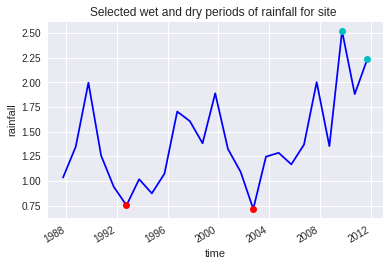

In [25]:
#Make a plot of the years we have chosen
year_avg_sp.rainfall.plot(color = 'b')
#here we index the dataset to plot the selected wet and dry years on top
wet1 = year_avg_sp.where(year_avg_sp.rainfall>=threshold95).rainfall.plot(color ='c', marker ='o')
dry1 = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).rainfall.plot(color = 'r', marker = 'o')
#FIXME fix the x ticks at some point
#plt.xticks(np.arange(1))
#print(ticker.get_xlim())
plt.title('Selected wet and dry periods of rainfall for site ')#+str(Studysite[0]))
plt.show()


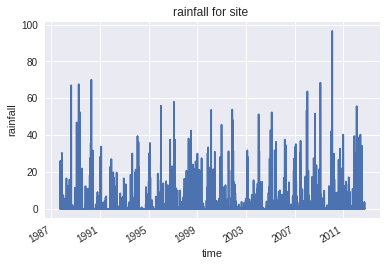

<xarray.Dataset>
Dimensions:   (time: 9132)
Coordinates:
  * time      (time) datetime64[ns] 1987-10-01 1987-10-02 1987-10-03 ...
Data variables:
    rainfall  (time) float32 0.000479939 3.28632 26.1184 0.156556 0.00848082 ...

In [26]:
#make a plot of rainfall for the wet and dry years that we have picked in here.
#first take a spatial average in lat and long 
rain_sp = Studysite_rain_masked.mean(dim = ('latitude','longitude'))
rain_sp.rainfall.plot()
plt.title('rainfall for site ')#+str(Studysite[0]))
plt.show()
rain_sp

In [27]:
print (max(rain_sp.rainfall))

<xarray.DataArray 'rainfall' ()>
array(96.50849914550781, dtype=float32)
Coordinates:
    time     datetime64[ns] 2010-01-31


In [28]:
type(rain_sp.rainfall.time.data[0])

numpy.datetime64

In [29]:
#make a plot of rainfall for the wet and dry years that we have picked in here.
#first take a spatial average in lat and long 
#then resample to get monthly averages?
rain_sp = Studysite_rain_masked.mean(dim = ('latitude','longitude'))
month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')

In [30]:
#select the months which are in our years
wet_dt
#print(wet_dt[0]+np.timedelta64(1,'Y'))

#set up end of years to finish our plots
end_wetyr = (wet_dt+np.timedelta64(1,'Y'))
#print(end_wetyr)
end_dryyr = (dry_dt+np.timedelta64(1,'Y'))

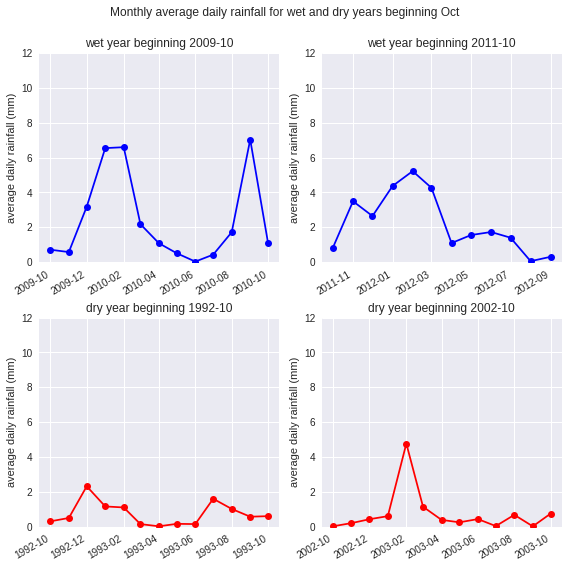

In [31]:
#set up 4 subplots to plot our 4 years
fig, axes = plt.subplots(nrows=2, ncols =2, figsize = (8,8))
#fig.suptitle('Monthly average daily rainfall for site '+str(Studysite[0]), fontsize = '14')

for i in range (0, len(wet_dt)):
    year_wrange = month_sp.rainfall.sel(time=slice(wet_dt[i],end_wetyr[i]))   
    #print(year_wrange.time.data)
    axes[0,i].plot(year_wrange.time.data, year_wrange.data, color='b', marker='o')
    axes[0,i].set_title('wet year beginning '+str(wet_dt[i]))
    axes[0,i].xaxis.set_label_position('bottom')
    axes[0,i].set_ylabel('average daily rainfall (mm)')
    axes[0,i].set_ylim(0,12)
    #axes[0,i].set_ylim(0,20)

for i in range (0, len(dry_dt)):
    year_drange = month_sp.rainfall.sel(time=slice(dry_dt[i],end_dryyr[i]))
    #print(year_drange.time.data)
    axes[1,i].plot(year_drange.time.data,year_drange.data, color ='r', marker = 'o')
    axes[1,i].set_title('dry year beginning '+str(dry_dt[i]))
    axes[1,i].xaxis.set_label_position('bottom')
    axes[1,i].set_ylabel('average daily rainfall (mm)')
    axes[1,i].set_ylim(0,12)
    #xes[1,i].set_xticks(np.r_drange.time.data)
    #axes[1,i].set_yticks(0,20,1)
    
#makes the labels the right angle
for ax in axes.ravel():
    for label in ax.get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment('right')
        
#add an extra pad around the graphs so the titles don't overlap        
plt.tight_layout(h_pad =1.0)
plt.subplots_adjust(top= 0.9)
plt.suptitle('Monthly average daily rainfall for wet and dry years beginning Oct')
plt.show()


Save rainfall years to netcdf and geotiff

In [32]:
#get the original dataset attributes (crs)
#set up variable attributes to hold the attributes from Studysite_rain
attrs = Studysite_rain
#dump the rain info
rain_data = attrs.data_vars.keys()
for i in rain_data:
    #drop band data, retaining just the attributes
    attrs =attrs.drop(i)
#set up new variable called rain_var, and assign attributes to it in a dictionary
rain_vars = {'dates':''}
dates_data = attrs.assign(**rain_vars)
dates_data['dates'] = dates

This section only needs to be run when you want to create the netcdf and geotiff files the first time.
There is a way to do this in python using gdal but this is quick and reliable.

In [33]:
shape_name

'Gal_for_wetdry3_Nogrid_WGS84'

In [36]:
ncpath = '/g/data/r78/rjd547/groundwater_activities/Rain/'
filename=ncpath+shape_name+'_060517.nc'
try:
    write_dataset_to_netcdf(dates_data,variable_params={'dates': {'zlib':True}},filename=filename)
    print('wrote to netcdf')
except RuntimeError as err:
    print("RuntimeError: {0}".format(err))


RuntimeError: Storage Unit already exists: /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517.nc


In [41]:
#using the gdal translate utility write the netcdf file to GeoTiff format
!module load gdal
!gdal_translate /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517.nc /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517.tif

Input file size is 26, 52
0...10...20...30...40...50...60...70...80...90...100 - done.


In [42]:
#open our GTiff with gdal
date_gt =gdal.Open(filename)
gdal.UseExceptions()
band = date_gt.GetRasterBand(1)
vals = band.ReadAsArray()
array = date_gt.ReadAsArray()
nodata = band.GetNoDataValue()

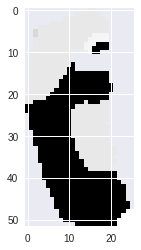

In [43]:
#check our tif worked
msk = vals==nodata
date_arr = np.ma.array(data=vals, mask=msk, fill_value=np.nan) 
plt.imshow(date_arr)
plt.show()

In [55]:

vals = vals.astype('int32')
vals[vals != -999]
print(vals)
#for validation, check that the histogram of the dates is ok
hist, bins = np.histogram(vals, range=(1986, 2014), bins=len(range(1986, 2014)))
print(hist)
#build a mask to mask nodata values when we create a shapefile
msk2 = mask.astype('uint8')
mask

[[-999 -999 -999 ..., -999 -999 -999]
 [-999 -999 -999 ..., -999 -999 -999]
 [-999 -999 -999 ..., -999 -999 -999]
 ..., 
 [-999 -999 -999 ..., 1990 1990 1990]
 [-999 -999 -999 ..., 1990 1990 1990]
 [-999 -999 -999 ..., 1990 1990 1990]]
[  0   0   0   0  13  15 351   2   0   0   0   0   0   0   0   0 494   0
   0   0   0   0   0   0   0   0   0   0]


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], dtype=bool)

In [66]:
#set up a filename stub so don't have to type it all the time:
filename_start=filename.split('.')[0]
print(filename_start)

/g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517


In [70]:
#create another tif file as a masking file 
with rasterio.open(filename_start+'.tif') as ds:
    jcrs = ds.crs
    jtransform = ds.transform
    
kwargs = {'count': 1, 'height': msk2.shape[0], 'width': msk2.shape[1], 'driver': 'GTiff',
          'dtype': 'uint8', 'crs': jcrs, 'transform': jtransform}
with rasterio.open(filename_start+'-mask.tif', 'w',
                   **kwargs) as outds:
    outds.write(msk2, 1)
print('wrote mask file: ', filename_start+'-mask.tif')

wrote mask file:  /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517-mask.tif


In [71]:
#check that the files are in this directory:
!ls /g/data/r78/rjd547/groundwater_activities/Rain/*.tif

/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_260417new.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_260417_sv10.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_260417_sv40.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_backup.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2-mask.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_sieved.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_sv10.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_sv20.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_sv2.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_sv3.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2_sv40.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Burdekin_River_NCBL2.tif
/g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdr

In [63]:
# # filter out polygons of less than 10 x 10 pixels
!gdal_sieve.py -st 10 -4 /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517.tif -mask /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517-mask.tif /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517_sieve10.tif


0...10...20...30...40...50...60...70...80...90...100 - done.


In [72]:
# #create a shapefile of output polygons
#change the masking file to the one you have created, change the sieved file to the new one, then give the new shapefile a name
!gdal_polygonize.py -mask /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517-mask.tif /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517_sieve10.tif -f "ESRI Shapefile"  /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517.shp

Creating output /g/data/r78/rjd547/groundwater_activities/Rain/Gal_for_wetdry3_Nogrid_WGS84_060517.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.


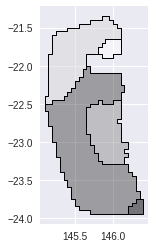

In [73]:
#have a look at the final resul to see if it looks ok!
import geopandas as gpd
big_poly = gpd.read_file(filename_start+'.shp')
big_poly.plot()
plt.show()

In [74]:
big_poly

,DN,geometry
0,1991,"POLYGON ((145.9 -21.65, 146.1 -21.65, 146.1 -2..."
1,1992,"POLYGON ((145.85 -21.35, 145.95 -21.35, 145.95..."
2,1992,"POLYGON ((145.8 -22.45, 145.85 -22.45, 145.85 ..."
3,2002,"POLYGON ((145.65 -22, 145.7 -22, 145.7 -22.1, ..."
4,1990,"POLYGON ((146.3 -23.75, 146.4 -23.75, 146.4 -2..."


# at the end of this notebook, you should have a functioning shapefile with polygons of common dry years based on the average daily dry season rainfall for each area. This shapefile can then be gridded in QGIS and run through "Regional Wettest Driest" notebook to get percentile wettest and driest rainfall years.